# Predicting Genre based on Black Friday Transactions

### 1. Getting the data

In [10]:
# importing modules
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import category_encoders as ce
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from scipy.stats import randint
import warnings
warnings.filterwarnings('ignore')

In [2]:
# loading the data
sales = pd.read_csv('black-friday.zip')
sales.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [24]:
# checking for missing values
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537577 entries, 0 to 537576
Data columns (total 10 columns):
User_ID                       537577 non-null int64
Product_ID                    537577 non-null object
Gender                        537577 non-null int64
Age                           537577 non-null object
Occupation                    537577 non-null object
City_Category                 537577 non-null object
Stay_In_Current_City_Years    537577 non-null object
Marital_Status                537577 non-null object
Product_Category_1            537577 non-null object
Purchase                      537577 non-null int64
dtypes: int64(3), object(7)
memory usage: 41.0+ MB


In [3]:
# deleting columns that won't be used
sales = sales.drop(['Product_Category_2', 'Product_Category_3'], axis=1)

In [25]:
# the data is unbalanced
sales['Gender'].value_counts()

1    405380
0    132197
Name: Gender, dtype: int64

### 2. Exploratory analysis

In [26]:
# create a function to easily plot figures
def barplot(index, column, title):
    pd.crosstab(index,column).plot(kind='bar', stacked=True, rot=0, alpha=0.5, align='center', width=0.7)
    # remove all the ticks (both axes)
    plt.tick_params(top=False, bottom=False, left=True, right=False, labelleft=True, labelbottom=True)
    # remove the frame of the chart
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.title(title)
    plt.ylabel('Transactions')
    plt.show()

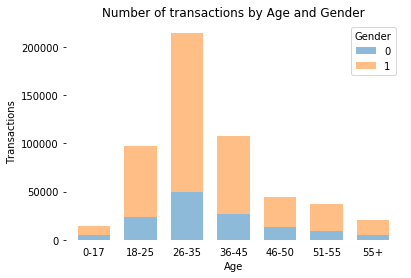

In [27]:
barplot(sales['Age'], sales['Gender'], 'Number of transactions by Age and Gender')

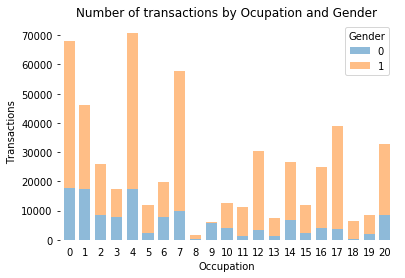

In [29]:
barplot(sales['Occupation'], sales['Gender'], 'Number of transactions by Ocupation and Gender')

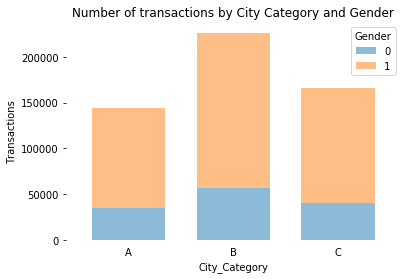

In [30]:
barplot(sales['City_Category'], sales['Gender'], 'Number of transactions by City Category and Gender')

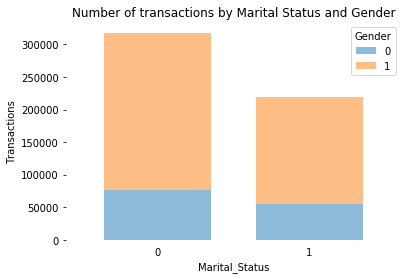

In [31]:
barplot(sales['Marital_Status'], sales['Gender'], 'Number of transactions by Marital Status and Gender')

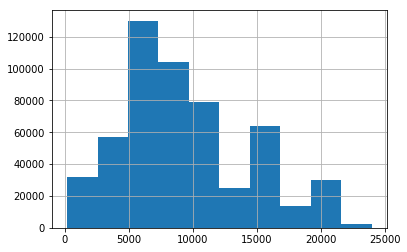

In [32]:
sales['Purchase'].hist()

In [33]:
sales['Purchase'].describe()

count    537577.000000
mean       9333.859853
std        4981.022133
min         185.000000
25%        5866.000000
50%        8062.000000
75%       12073.000000
max       23961.000000
Name: Purchase, dtype: float64

### 3. Building a Predicitive Model

#### 3.1 Pre-Processing Data

In [4]:
# specify seed for reproducable results
seed=42

# label the response
sales['Gender'] = sales['Gender'].map({'F':0, 'M':1})

# convert all categorical variables to object dtype, so the binery encoder will process them
cat_attribs = sales.drop(['Gender', 'Purchase', 'User_ID'], axis=1)
to_object = list(cat_attribs)
for i in to_object:
    sales[i] = sales[i].astype("object")
    
# split dataframe into training and test set
train_set, test_set = train_test_split(sales, test_size=0.33, random_state=seed)

In [11]:
cat_attribs = list(cat_attribs)
num_attribs = ['Purchase', 'User_ID']

# standarize and Binary Encode features
pipeline = ColumnTransformer([
    ('num', StandardScaler(), num_attribs),
    ('cat', ce.BinaryEncoder(), cat_attribs)    
    ,])

sales_prepared = pipeline.fit_transform(train_set)

In [12]:
# new dataframe shape
sales_prepared.shape

(360176, 40)

#### 3.2. Oversampling the minority class

In [13]:
sm = SMOTE(random_state=seed)
X_train_res, y_train_res = sm.fit_resample(sales_prepared, train_set['Gender'])

In [14]:
X_train_res.shape

(543746, 40)

In [15]:
# checking balance between classes
unique, counts = np.unique(y_train_res, return_counts=True)
dict(zip(unique, counts))

{0: 271873, 1: 271873}

#### 3.3. Predictive models

For this classification problem I will try 3 different models:

- Logistic Regression
- Random Forest

Let's evaluate them:

In [18]:
# define models
models = {'Logistic Regression':LogisticRegression(solver='liblinear', random_state=seed),  
         'Random Forest':RandomForestClassifier(n_estimators=20, n_jobs=-1, random_state=seed)}

y_pred = pd.DataFrame(columns=models.keys())
results = []

# train, predict and evaluate each model
for model in models.keys():  
    acc_score = cross_val_score(models[model], X_train_res, y_train_res, scoring="accuracy", cv=5)
    f1_score = cross_val_score(models[model], X_train_res, y_train_res, scoring="f1", cv=5)
    roc_auc_score = cross_val_score(models[model], X_train_res, y_train_res, scoring="roc_auc", cv=5)
    results.append({'Accuracy': acc_score.mean(),
                    'F1-Score': f1_score.mean(),
                    'ROC AUC': roc_auc_score.mean(),
                    'Model': str(model)})

In [19]:
results = pd.DataFrame(results)
results.sort_values('F1-Score', inplace=True, ascending=False)
results = results.set_index('Model')
results

,Accuracy,F1-Score,ROC AUC
Model,,,
Random Forest,0.947674,0.950764,0.990080
Logistic Regression,0.595914,0.588402,0.636464


Random Forest is the best model in terms of **ROC AUC, F-1 Score and Accuracy**

#### 3.4. Tunning the model

In [20]:
# parameters to try
param_grid = [
    {'n_estimators': [30, 40, 50], 'max_features': ['sqrt','log2']},
  ]

clf = RandomForestClassifier(n_jobs=-1,random_state=seed)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1', return_train_score=True)
grid_search.fit(X_train_res, y_train_res)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [30, 40, 50], 'max_features': ['sqrt', 'log2']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='f1', verbose=0)

#### 3.5. Evaluating the model

In [22]:
# making predictions and evaluating the model on the test set
final_model = grid_search.best_estimator_

X_test = test_set.drop('Gender', axis=1)
y_test = test_set['Gender'].copy()

X_test_prepared = pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
print(classification_report(y_test, final_predictions))

              precision    recall  f1-score   support

           0       0.93      0.76      0.84     43894
           1       0.93      0.98      0.95    133507

   micro avg       0.93      0.93      0.93    177401
   macro avg       0.93      0.87      0.90    177401
weighted avg       0.93      0.93      0.93    177401



In [23]:
grid_search.best_params_

{'max_features': 'sqrt', 'n_estimators': 50}